<a href="https://colab.research.google.com/github/AnastasiaZhivilo/AnastasiaZhivilo/blob/main/DATA5703_Capstone_Project/model_training/DualHead_U_Net_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 43.8 MB/s eta 0:00:00


In [12]:
import ee
import google.colab.drive as drive
import rasterio
import numpy as np
import os
import glob
from scipy.ndimage import convolve, binary_dilation
from skimage.util import view_as_windows
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [13]:
ee.Authenticate()
ee.Initialize(project='cs88-2-capstone')
print("Earth Engine authenticated and initialized.")

Earth Engine authenticated and initialized.


In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


# Part 1 - Data Prep

In [16]:

ROOT_DATA_DIR = '/content/drive/MyDrive/Capstone/Raw_data/'

PATCH_SIZE = 128
OVERLAP = 64
STRIDE = PATCH_SIZE - OVERLAP
TEST_SIZE = 0.15     # 15% for initial test set
VALIDATION_SIZE = 0.15  # 15% for validation (taken from remaining training set)
RANDOM_SEED = 42      # For reproducible splits

INPUT_CHANNELS = 35
BOUNDARY_DILATION_RADIUS = 3 # This corresponds to a 5x5 kernel (2 pixels on each side of the line)

COMPRESSION_CHANNELS = 20 # Reducing 35 channels down to 20 for efficiency

# --- Configuration (Ensure these match your notebook config!) ---
R_BAND_IDX, G_BAND_IDX, B_BAND_IDX = 2, 1, 0
Z_MIN = -3.0
Z_MAX = 3.0

In [17]:
# --- 1. Utility Functions ---

def z_score_normalize(data):
    """Applies Z-Score normalization (mean=0, std=1) to a multi-band array (C, H, W)."""
    C, H, W = data.shape
    data_reshaped = data.reshape(C, H * W)
    mean = data_reshaped.mean(axis=1, keepdims=True)
    std = data_reshaped.std(axis=1, keepdims=True)
    std[std == 0] = 1e-6
    normalized_data = ((data_reshaped - mean) / std).reshape(C, H, W)
    return normalized_data

def generate_patches(data_array, patch_size, stride):
    """
    Generates overlapping patches from a multi-channel (C, H, W) array
    and returns a sequential index array for each patch for reconstruction.
    """
    data_hwc = np.moveaxis(data_array, 0, -1)

    patches = view_as_windows(
        data_hwc,
        (patch_size, patch_size, data_hwc.shape[-1]),
        step=stride
    )

    N_row_patches, N_col_patches, _, H, W, C = patches.shape
    patches_flat = patches.reshape(-1, H, W, C)

    sequential_indices = np.arange(patches_flat.shape[0])

    return patches_flat, sequential_indices



In [18]:
def process_single_box(data_dir, display_mask=False):
    """
    Loads S2 data and the two PRE-GENERATED mask files for one BBox folder.
    """
    print(f"\n--- Processing: {os.path.basename(data_dir)} ---")

# ---------------------------------------------------------------------
# --- Part A: Create Input Stack (X) (CLEANED AND FIXED) ---
# ---------------------------------------------------------------------

    s2_files = sorted(glob.glob(os.path.join(data_dir, 'Sentinel2_*.tif')))
    semantic_mask_files = glob.glob(os.path.join(data_dir, '*_Semantic_Mask.tif'))
    separator_target_files = glob.glob(os.path.join(data_dir, '*_Separator_Target.tif'))

    num_files = len(s2_files)
    EXPECTED_BANDS_PER_FILE = 7
    EXPECTED_TOTAL_BANDS = num_files * EXPECTED_BANDS_PER_FILE

    # 1. CRITICAL: Check for file existence first.
    if num_files == 0 or not semantic_mask_files or not separator_target_files:
        print(f"SKIPPING: Required files not found in {os.path.basename(data_dir)}")
        return None, None, None, None, None

    # Now it is safe to define mask paths
    semantic_mask_path = semantic_mask_files[0]
    separator_target_path = separator_target_files[0]

    # 2. Get H, W and dtype from the first S2 file
    try:
        with rasterio.open(s2_files[0]) as src:
            H, W = src.shape
            # Removed redundant dtype definition for cleanliness
    except Exception as e:
        print(f"Error opening first S2 file for shape: {e}")
        return None, None, None, None, None

    print(f"DEBUG: Found {num_files} Sentinel2 files. Expected 5 (35 bands total).")

    # 3. Pre-allocate X_raw for the full 35 bands (based on the first block's logic)
    X_raw = np.full((EXPECTED_TOTAL_BANDS, H, W), np.nan, dtype=np.float32)
    bands_loaded_count = 0

    # 4. Data Loading Loop (This loop is correct)
    for file_idx, fpath in enumerate(s2_files):
        start_band_idx = file_idx * EXPECTED_BANDS_PER_FILE

        try:
            with rasterio.open(fpath) as src:
                data_all_bands = src.read().astype(np.float32)

                if data_all_bands.shape[0] != EXPECTED_BANDS_PER_FILE:
                    print(f"ERROR: File {os.path.basename(fpath)} has {data_all_bands.shape[0]} bands, expected {EXPECTED_BANDS_PER_FILE}. SKIPPING.")
                    continue

                X_raw[start_band_idx : start_band_idx + EXPECTED_BANDS_PER_FILE, :, :] = data_all_bands
                bands_loaded_count += data_all_bands.shape[0]

        except Exception as e:
            print(f"ERROR: Failed to load file {os.path.basename(fpath)}. Error: {e}. Leaving 7 bands as NaN.")
            continue

    # 5. Sanity Check and Normalization
    if bands_loaded_count < EXPECTED_TOTAL_BANDS:
        print(f"WARNING: Only loaded {bands_loaded_count} out of {EXPECTED_TOTAL_BANDS} bands. Proceeding with missing bands as NaN.")

    if bands_loaded_count == 0:
        print(f"FATAL: Zero bands loaded successfully for {os.path.basename(data_dir)}. SKIPPING.")
        return None, None, None, None, None

    # Transpose X_raw from (C, H, W) to (H, W, C) for Z-score normalization
    X_raw_norm_ready = np.transpose(X_raw, (1, 2, 0))

    X_normalized = z_score_normalize(X_raw_norm_ready)
    X_normalized = np.transpose(X_normalized, (2, 0, 1)) # Transpose back to (C, H, W)

# ---------------------------------------------------------------------
# --- Part B: Load and Process BOTH Pre-Generated Masks (Y1 and Y2) ---
# ---------------------------------------------------------------------

    # Y1: Semantic Mask (3-Class: 0, 1, 2)
    # ... (Rest of the function is now correct as it uses the defined H, W, and paths) ...
# --- Part B: Load and Process BOTH Pre-Generated Masks (Y1 and Y2) ---

    # Y1: Semantic Mask (3-Class: 0, 1, 2)
    try:
        with rasterio.open(semantic_mask_path) as src:
            # Mask is stored as byte (uint8), load as float for consistency
            semantic_mask = src.read(1).astype(np.float32)
    except Exception as e:
        print(f"Error loading Semantic Mask file: {e}")
        return None, None

    # Y2: Separator Target (1-Class: 0, 1)
    try:
        with rasterio.open(separator_target_path) as src:
            # Mask is stored as byte (uint8), load as float for consistency
            separator_target = src.read(1).astype(np.float32)
    except Exception as e:
        print(f"Error loading Separator Target file: {e}")
        return None, None

    # Sanity check for dimensions
    if semantic_mask.shape != (H, W) or separator_target.shape != (H, W):
         print(f"ERROR: Mask shapes do not match S2 shape ({H}, {W}). SKIPPING.")
         return None, None

    # Dilating the 'Boundary/Edge' class (Value 2) to give the model a wider target area.
    if BOUNDARY_DILATION_RADIUS > 0:
        # Create a boolean mask ONLY for the boundary class (Value 2)
        boundary_bool = semantic_mask == 2

        # Dilate the boundary pixels
        dilated_boundary_bool = binary_dilation(
            boundary_bool,
            structure=np.ones((BOUNDARY_DILATION_RADIUS, BOUNDARY_DILATION_RADIUS), dtype=bool)
        )

        # Update the semantic mask:
        dilated_semantic_mask = np.zeros_like(semantic_mask)

        # Set Interior (original semantic mask value 1) to 1
        interior_bool = semantic_mask == 1
        dilated_semantic_mask[interior_bool] = 1

        # Set Boundary (dilated area) to 2. This overwrites some '1's near the edge.
        dilated_semantic_mask[dilated_boundary_bool] = 2

        # Final check: Don't let dilation affect the Non-Crop Area (Value 0)
        # Non-Crop areas in the original mask must remain 0
        non_crop_bool = semantic_mask == 0
        dilated_semantic_mask[non_crop_bool] = 0

        semantic_mask = dilated_semantic_mask
        print(f"   -> Semantic Mask's Class 2 (Boundary) dilated by {BOUNDARY_DILATION_RADIUS}x{BOUNDARY_DILATION_RADIUS}.")


    # --- Part C: Prepare final output arrays ---

    # Y1_final: Semantic Mask (3-Class: 0, 1, 2) - Shape (1, H, W)
    Y1_final = semantic_mask[np.newaxis, :, :]

    # Y2_final: Separator Target (1-Class: 0, 1) - Shape (1, H, W)
    # The Separator Target already has a thin line (Value 1) and does not need thickening for this task.
    Y2_final = separator_target[np.newaxis, :, :]

    # ------------------------------------------------------------------
    # Visualization
    # ------------------------------------------------------------------
    if display_mask:
        # Define Color Maps for Visualization
        # Semantic Mask (Y1): 0-Non-Crop (Blue), 1-Interior (Green), 2-Boundary (Red)
        cmap_semantic = mcolors.ListedColormap(['#1f77b4', '#2ca02c', '#d62728'])
        # Separator Target (Y2): 0-Background (Black), 1-Separator (White/Yellow)
        cmap_separator = mcolors.ListedColormap(['black', 'yellow'])

        # Prepare RGB Image for Display
        # Assuming your input stack X_normalized has bands R=2, G=1, B=0 (or similar config)
        # and using Z_MIN/Z_MAX for scaling (defined globally)
        rgb_display = X_normalized[[R_BAND_IDX, G_BAND_IDX, B_BAND_IDX], :, :]
        # Clip and scale to 0-1 for display
        rgb_image = np.clip((rgb_display - Z_MIN) / (Z_MAX - Z_MIN), 0, 1)
        # Transpose to (H, W, C) for matplotlib
        rgb_image = np.transpose(rgb_image, (1, 2, 0))


        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(f"Processed BBox: {os.path.basename(data_dir)}", fontsize=16)

        # Plot 1: Input Image
        axes[0].imshow(rgb_image)
        axes[0].set_title('Input Image (RGB)')
        axes[0].axis('off')

        # Plot 2: Semantic Mask (Y1)
        # Squeeze Y1_final to remove the channel dimension
        axes[1].imshow(Y1_final.squeeze(), cmap=cmap_semantic, vmin=0, vmax=2)
        axes[1].set_title(f'Semantic Mask (Y1) | Dilation: {BOUNDARY_DILATION_RADIUS}')
        axes[1].axis('off')

        # Plot 3: Separator Target (Y2)
        # Squeeze Y2_final to remove the channel dimension
        axes[2].imshow(Y2_final.squeeze(), cmap=cmap_separator, vmin=0, vmax=1)
        axes[2].set_title('Separator Target (Y2)')
        axes[2].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    print(f"X_normalized shape: {X_normalized.shape} | Y1_final shape: {Y1_final.shape} | Y2_final shape: {Y2_final.shape}")

    return X_normalized, Y1_final, Y2_final, H, W #  Return BOTH masks

Found 5 BBox directories to process.

--- Processing: BBox_147_1519__34_2800 ---
DEBUG: Found 5 Sentinel2 files. Expected 5 (35 bands total).
   -> Semantic Mask's Class 2 (Boundary) dilated by 3x3.


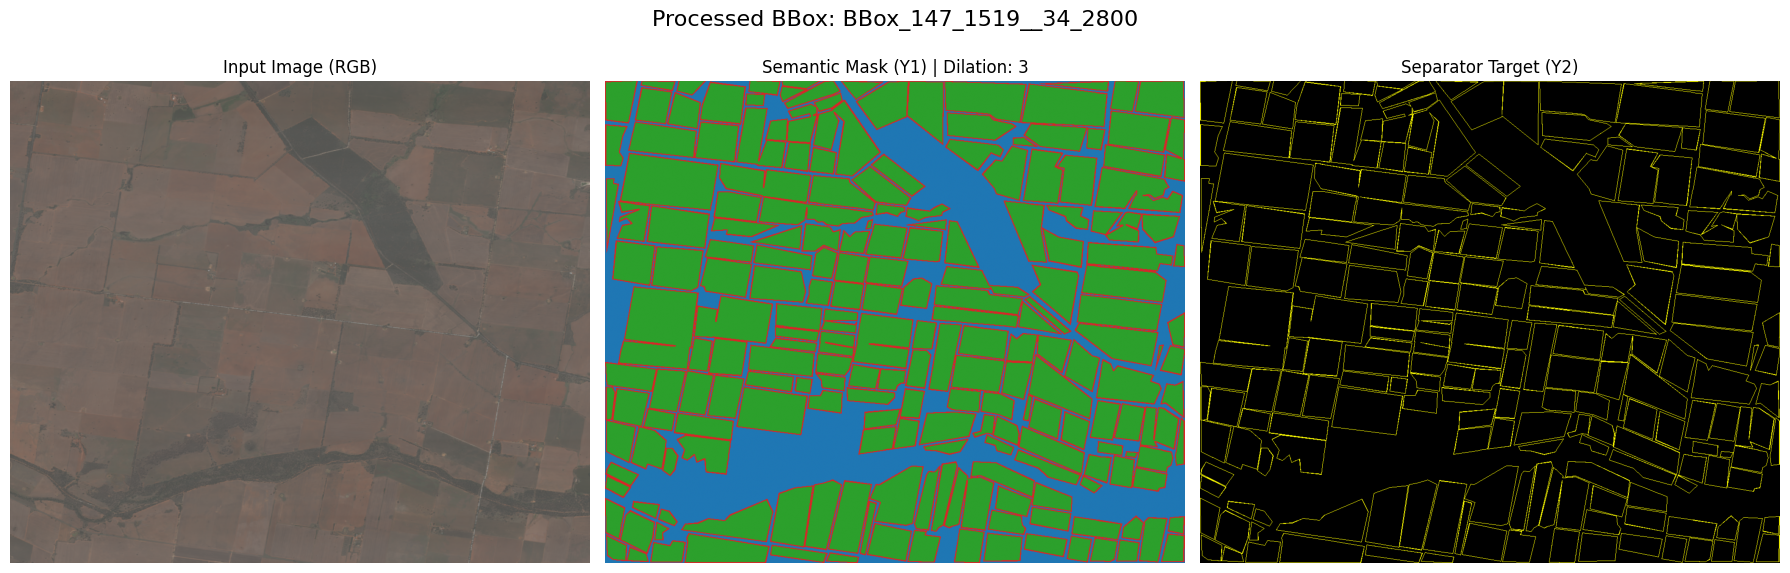

X_normalized shape: (35, 1002, 1205) | Y1_final shape: (1, 1002, 1205) | Y2_final shape: (1, 1002, 1205)
   -> Generated 238 patches.

--- Processing: BBox_147_4101__34_5097 ---
DEBUG: Found 5 Sentinel2 files. Expected 5 (35 bands total).
   -> Semantic Mask's Class 2 (Boundary) dilated by 3x3.
X_normalized shape: (35, 1002, 1209) | Y1_final shape: (1, 1002, 1209) | Y2_final shape: (1, 1002, 1209)
   -> Generated 238 patches.

--- Processing: BBox_147_5855__34_2255 ---
DEBUG: Found 5 Sentinel2 files. Expected 5 (35 bands total).
   -> Semantic Mask's Class 2 (Boundary) dilated by 3x3.
X_normalized shape: (35, 1003, 1204) | Y1_final shape: (1, 1003, 1204) | Y2_final shape: (1, 1003, 1204)
   -> Generated 238 patches.

--- Processing: BBox_147_6049__34_8720 ---
DEBUG: Found 5 Sentinel2 files. Expected 5 (35 bands total).
   -> Semantic Mask's Class 2 (Boundary) dilated by 3x3.
X_normalized shape: (35, 1003, 1214) | Y1_final shape: (1, 1003, 1214) | Y2_final shape: (1, 1003, 1214)
   -> G

In [19]:
def main_data_pipeline(root_dir):
    """Finds all BBox folders, processes them, aggregates patches, and splits data."""

    # 1. Find all bounding box folders (remains the same)
    bbox_folders = sorted(glob.glob(os.path.join(root_dir, 'BBox_*')))
    if not bbox_folders:
        print(f"Error: No folders starting with 'BBox_' found in {root_dir}")
        return

    all_X_patches = []
    all_Y1_patches = [] # Y1: Semantic Mask (3-class)
    all_Y2_patches = [] # Y2: Separator Target (1-class)
    all_patch_sources = []
    all_patch_indices = []

    bbox_dims = {}

    print(f"Found {len(bbox_folders)} BBox directories to process.")

    # 2. Process each folder individually
    for i, folder_path in enumerate(bbox_folders):
        bbox_name = os.path.basename(folder_path)

        # 🛑 CHANGE 1: Capture the three return values
        X_data, Y1_mask, Y2_mask, H_orig, W_orig = process_single_box(folder_path, display_mask=(i == 0))

        if X_data is not None:
            bbox_dims[bbox_name] = (H_orig, W_orig)
            # Generate patches for X (remains the same)
            X_patches_box, indices_box = generate_patches(X_data, PATCH_SIZE, STRIDE)

            # Generate patches for Y1 (Semantic Mask)
            Y1_mask_sq = np.squeeze(Y1_mask, axis=0) # (H, W)
            Y1_patches_raw = generate_patches(Y1_mask_sq[np.newaxis, :, :], PATCH_SIZE, STRIDE)[0]
            Y1_patches_box = Y1_patches_raw.reshape(Y1_patches_raw.shape[0], PATCH_SIZE, PATCH_SIZE, 1)

            # Generate patches for Y2 (Separator Target)
            Y2_mask_sq = np.squeeze(Y2_mask, axis=0) # (H, W)
            Y2_patches_raw = generate_patches(Y2_mask_sq[np.newaxis, :, :], PATCH_SIZE, STRIDE)[0] # (N, H, W, 1)
            Y2_patches_box = Y2_patches_raw.reshape(Y2_patches_raw.shape[0], PATCH_SIZE, PATCH_SIZE, 1)

            # Append to the master lists
            all_X_patches.append(X_patches_box)
            all_Y1_patches.append(Y1_patches_box)
            all_Y2_patches.append(Y2_patches_box) # Append Y2 patches

            # Append the sequential indices and source names
            all_patch_sources.extend([bbox_name] * indices_box.shape[0])
            # Append the sequential indices for this box
            all_patch_indices.append(indices_box)

            print(f"   -> Generated {X_patches_box.shape[0]} patches.")

     # 3. Aggregate all patches from all boxes
    X_combined = np.concatenate(all_X_patches, axis=0)
    Y1_combined = np.concatenate(all_Y1_patches, axis=0) # Y1
    Y2_combined = np.concatenate(all_Y2_patches, axis=0) # Y2
    Source_combined = np.array(all_patch_sources)
    Index_combined = np.concatenate(all_patch_indices, axis=0)

  # FIX: NaN Imputation
    # X_combined currently holds the 8.8 million NaNs that came from X_normalized.
    # We replace them with 0.0 before splitting the data.
    initial_nan_count = np.count_nonzero(np.isnan(X_combined))
    if initial_nan_count > 0:
        print(f"    -> WARNING: Found {initial_nan_count:,.0f} NaN values in X_combined. Replacing with 0.0...")
        X_combined[np.isnan(X_combined)] = 0.0
        print("    -> NaN replacement complete. Proceeding with split.")
    # -----------------------------------


    # 4. Perform final train/val/test split (Step 1.3)

    # Initial Split: Train+Val vs. Test
    X_tv, X_test, Y1_tv, Y1_test, Y2_tv, Y2_test, Source_tv, Source_test, Index_tv, Index_test = train_test_split(
        X_combined,
        Y1_combined,
        Y2_combined, # New Y2 array
        Source_combined,
        Index_combined, # Now passing 5 arrays
        test_size=TEST_SIZE,
        random_state=RANDOM_SEED
    )

    # Secondary Split: Train vs. Validation
    validation_relative_size = VALIDATION_SIZE / (1 - TEST_SIZE)

    X_train, X_val, Y1_train, Y1_val, Y2_train, Y2_val, Source_train, Source_val, Index_train, Index_val = train_test_split(
        X_tv,
        Y1_tv,
        Y2_tv, # New Y2 array
        Source_tv,
        Index_tv, # Now correctly using the index from the previous split
        test_size=validation_relative_size,
        random_state=RANDOM_SEED
    )

    print("\n--- Final Data Split Summary ---")
    print(f"Total Patches: {X_combined.shape[0]}")
    print(f"Training Samples (X_train):   {X_train.shape[0]}")
    print(f"Validation Samples (X_val):   {X_val.shape[0]}")
    print(f"Testing Samples (X_test):     {X_test.shape[0]}")
    print("\nALL DATA PREPARATION COMPLETE. Proceed to Step 2: U-Net Model.")

    return X_train, Y1_train, Y2_train, X_val, Y1_val, Y2_val, X_test, Y1_test, Y2_test, Source_test, Index_test, bbox_dims

# --- Execution ---
if __name__ == '__main__':
    X_train, Y1_train, Y2_train, X_val, Y1_val, Y2_val, X_test, Y1_test, Y2_test, Source_test, Index_test, bbox_dims = main_data_pipeline(ROOT_DATA_DIR)

# Part 2 - Model Training

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Add
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# --- Configuration (Based on your input) ---

INPUT_SHAPE = (PATCH_SIZE, PATCH_SIZE, INPUT_CHANNELS)
OUTPUT_CHANNELS = 1

# --- Custom Loss and Metric (From previous steps) ---
def dice_coefficient(y_true, y_pred):
    """Calculates the Dice Coefficient (F1 Score) for segmentation."""
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
# --- Custom Loss and Metric (Modified for Weighting) ---

# Define the weight for the positive class (boundaries).
# Start with a moderate value like 10-15 and adjust if needed.
# W_p = 15 means the loss incurred on a positive pixel is 15 times greater than a negative pixel.
W_p = 1.0

def unweighted_dice_loss(y_true, y_pred):
    """Calculates the standard (unweighted) Dice Loss."""
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    sum_of_labels = K.sum(y_true_f) + K.sum(y_pred_f)

    dice_coefficient = (2. * intersection + smooth) / (sum_of_labels + smooth)

    # Loss is 1 - Dice Coefficient
    return 1.0 - dice_coefficient

def residual_block(input_tensor, filters):
    """
    Updated Residual Block with a Projection Shortcut (1x1 Conv)
    to handle changes in the number of filters.
    """
    input_filters = K.int_shape(input_tensor)[-1]

    # 1. Main Path
    conv = Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(input_tensor)
    conv = BatchNormalization(axis=-1)(conv)
    conv = Activation('relu')(conv)

    conv = Conv2D(filters, 3, padding='same', kernel_initializer='he_normal')(conv)
    conv = BatchNormalization(axis=-1)(conv)

    # 2. Skip Connection (Residual)

    # Check if the number of filters has changed.
    if input_filters != filters:
        # If filters change (e.g., 16 -> 32), use a 1x1 convolution (Projection Shortcut)
        shortcut = Conv2D(filters, 1, strides=1, padding='same', kernel_initializer='he_normal')(input_tensor)
        shortcut = BatchNormalization(axis=-1)(shortcut)
    else:
        # If filters remain the same (e.g., 32 -> 32), use the identity shortcut
        shortcut = input_tensor

    # The Add layer combines the shortcut with the main path output
    output = Add()([shortcut, conv])

    # 3. Final Activation
    output = Activation('relu')(output)

    return output



In [21]:
# --- ResUNet Model Construction ---
# NOTE: We now output 2 separate masks. The model will need two names for these outputs.
def build_dual_head_resunet_model(input_shape, compression_channels=COMPRESSION_CHANNELS):
    """
    Constructs the U-Net model using Residual Blocks in the encoder (ResUNet)
    and incorporates a DUAL HEAD for Semantic (Y1) and Separator (Y2) prediction.
    """

    inputs = Input(input_shape)

    # 🛑 NEW: 1x1 Convolution for Channel Compression 🛑 (Same as before)
    compression_output = Conv2D(
        filters=compression_channels,
        kernel_size=(1, 1),
        padding='same',
        activation='relu',
        kernel_initializer='he_normal',
        name="channel_compressor"
    )(inputs)

    # --- ENCODER (Contracting Path - NO CHANGE) ---
    # Level 1
    conv_init = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(compression_output)
    conv1 = residual_block(conv_init, 16)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Level 2
    conv2 = residual_block(pool1, 32)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Level 3
    conv3 = residual_block(pool2, 64)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Level 4
    conv4 = residual_block(pool3, 128)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Level 5 (Bottom)
    conv5 = residual_block(pool4, 256)
    conv5 = residual_block(conv5, 256)

    # --- DECODER (Expanding Path - NO CHANGE) ---
    # Level 4 Up
    up4 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv5))
    merge4 = concatenate([conv4, up4], axis=-1)
    conv10 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge4)
    conv10 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv10)

    # Level 3 Up
    up3 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv10))
    merge3 = concatenate([conv3, up3], axis=-1)
    conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    # Level 2 Up
    up2 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge2 = concatenate([conv2, up2], axis=-1)
    conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge2)
    conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    # Level 1 Up
    up1 = Conv2D(16, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge1 = concatenate([conv1, up1], axis=-1)
    conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1)
    # The final shared feature map before output
    final_features = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)


    # ----------------------------------------------------------------------
    # ----------------------------------------------------------------------

    # HEAD 1: Semantic Segmentation (3 Classes: 0, 1, 2)
    # Since our classes are discrete categories (and we are using a 3-class target),
    # we use 'softmax' activation and an output channel count of 3.
    semantic_output = Conv2D(
        filters=3, # 3 classes: Non-Crop, Interior, Boundary
        kernel_size=1,
        activation='softmax',
        name='semantic_output' # IMPORTANT: Name the output
    )(final_features)

    # HEAD 2: Separator Target Prediction (Binary: 0, 1)
    # Since this is a binary mask (line present or not), we use 'sigmoid' activation.
    separator_output = Conv2D(
        filters=1, # 1 channel output (0 or 1)
        kernel_size=1,
        activation='sigmoid',
        name='separator_output' # IMPORTANT: Name the output
    )(final_features)


    # ----------------------------------------------------------------------

    # Model definition with one input and two outputs
    model = Model(inputs=inputs, outputs=[semantic_output, separator_output])

    return model

In [22]:
# --- STEP 3A: One-Hot Encode the Semantic Mask (Y1) ---
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

EPOCHS = 50           # Start with 50, but monitor validation loss
BATCH_SIZE = 32       # Standard batch size, adjust if memory is an issue


# Y1_train has shape (N, H, W, 1) with values 0, 1, 2.
# We need to reshape the mask to (N*H*W, 1) for to_categorical, then reshape back.
N_train, H, W, C = Y1_train.shape
N_val, _, _, _ = Y1_val.shape
NUM_CLASSES = 3

Y1_train_flat = Y1_train.reshape(-1, 1)
Y1_val_flat = Y1_val.reshape(-1, 1)

Y1_train_one_hot = to_categorical(Y1_train_flat, num_classes=NUM_CLASSES)
Y1_val_one_hot = to_categorical(Y1_val_flat, num_classes=NUM_CLASSES)

# Reshape back to the Keras expected tensor format
Y1_train_one_hot = Y1_train_one_hot.reshape(N_train, H, W, NUM_CLASSES)
Y1_val_one_hot = Y1_val_one_hot.reshape(N_val, H, W, NUM_CLASSES)

print(f"Y1_train (Semantic) One-Hot Shape: {Y1_train_one_hot.shape}")


# 1. Instantiate the new Dual-Head ResUNet model
model = build_dual_head_resunet_model(INPUT_SHAPE)

# 2. Define the loss function for each output head
# We use Keras's built-in Categorical Crossentropy for the 3-class semantic head
# And your custom Dice Loss for the 1-channel separator target
loss_functions = {
    'semantic_output': 'categorical_crossentropy',
    'separator_output': unweighted_dice_loss
}

# 3. Define the relative weight for each loss (Crucial for balancing the heads)
# Semantic (Y1) is the primary goal, so give it higher weight.
# Separator (Y2) is secondary but critical for instance separation.
loss_weights = {
    'semantic_output': 1.0,
    'separator_output': 10.0
}

# 4. Define metrics for each output head
metrics_to_use = {
    # Use accuracy/Dice for the multi-class semantic task
    'semantic_output': ['accuracy'],
    # Use your existing Dice Coefficient for the separator task
    'separator_output': [dice_coefficient]
}

optimizer = Adam(learning_rate=1e-5, clipvalue=1.0)

model.compile(
    optimizer='adam',
    loss={
        'semantic_output': 'categorical_crossentropy', # Or whatever you used
        'separator_output': unweighted_dice_loss
    },
    # CRITICAL: Pass the new loss weights
    loss_weights=loss_weights,
    metrics= metrics_to_use
)

# Optional: Print the model summary to see the layers and parameters
model.summary()

# --- Train the Model ---

# Ensure the targets are ordered to match the model outputs: [semantic_output, separator_output]

# Create the list of targets in the order the model expects them (Y1 then Y2)
# Y1_train_one_hot has shape (N, H, W, 3)
Y_train_targets = [Y1_train_one_hot, Y2_train]

# The same needs to be done for validation data
# Y1_val_one_hot has shape (N, H, W, 3)
Y_val_targets = [Y1_val_one_hot, Y2_val]


print("\n--- Starting Model Training ---")

history = model.fit(
    X_train,
    # Y_train_list, # List of target masks
    Y_train_targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    # validation_data=(X_val, Y_val_list), # List of validation masks
    validation_data=(X_val, Y_val_targets),
    shuffle=True
)

print("\n--- Training Complete ---")

# Save the trained model for later use
model.save('/content/drive/MyDrive/Capstone/field_boundary_unet_model.h5')
print("\nModel saved to Google Drive.")

Y1_train (Semantic) One-Hot Shape: (832, 128, 128, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 35)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ channel_compressor  │ (None, 128, 128,  │        720 │ input_layer[0][0] │
│ (Conv2D)            │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      2,896 │ channel_compress… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ conv2d[0][0],     │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │        544 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_5[0][0]  

 Total params: 3,178,740 (12.13 MB)

 Trainable params: 3,174,772 (12.11 MB)

 Non-trainable params: 3,968 (15.50 KB)


--- Starting Model Training ---
Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 391ms/step - loss: 9.9694 - semantic_output_accuracy: 0.6759 - semantic_output_loss: 0.7769 - separator_output_dice_coefficient: 0.0807 - separator_output_loss: 0.9193 - val_loss: 10.0666 - val_semantic_output_accuracy: 0.5862 - val_semantic_output_loss: 0.9530 - val_separator_output_dice_coefficient: 0.0876 - val_separator_output_loss: 0.9124
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 8.6962 - semantic_output_accuracy: 0.7775 - semantic_output_loss: 0.6397 - separator_output_dice_coefficient: 0.1944 - separator_output_loss: 0.8056 - val_loss: 9.7726 - val_semantic_output_accuracy: 0.7089 - val_semantic_output_loss: 0.7820 - val_separator_output_dice_coefficient: 0.1007 - val_separator_output_loss: 0.8993
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 7.8083 - semantic_output_accuracy: 0.7947 - semantic_output_loss: 0.5647 - separator_output_dice_coefficient: 0.2756 - separator_output


--- Training Complete ---

Model saved to Google Drive.


# Post Processing - Watershed

In [23]:
from skimage.segmentation import watershed
from scipy import ndimage
import numpy as np
from skimage.feature import peak_local_max

def watershed_post_processing(semantic_pred, separator_pred):
    """
    Applies the Watershed algorithm using the Semantic mask for the foreground
    and the Separator prediction to define the energy landscape.

    Args:
        semantic_pred (np.ndarray): The 3-class semantic prediction (H, W, 3).
        separator_pred (np.ndarray): The 1-channel binary boundary prediction (H, W, 1).

    Returns:
        np.ndarray: The final instance map where each field has a unique integer ID.
    """

    # 1. Get the Semantic Foreground Mask (Crop Interior OR Boundary)
    # Convert softmax (H, W, 3) to class indices (H, W)
    semantic_mask_class = np.argmax(semantic_pred, axis=-1)
    binary_field_mask = (semantic_mask_class > 0).astype(np.uint8) # 1 where crop is present (Interior or Boundary)

    # 2. Define the Energy Landscape for Splitting (Critical Step)
    # The standard is the negative distance map. We use the *inverse* of the separator prediction.
    # High separator prediction (close to 1.0) means 'split here'.
    # For watershed, we want the "valleys" (low elevation) to be the split points.

    # Option A: Distance Map (Robust, less reliance on Y2 pred)
    distance_map = ndimage.distance_transform_edt(semantic_mask_class == 1) # Distance from the Interior (Class 1)

    # Option B: Separator Prediction (Faster, relies on clean Y2 pred)
    # Invert the separator prediction: 1.0 at centers, 0.0 at boundaries.
    # This is a good *elevation map* for the watershed algorithm.
    elevation_map = 1.0 - separator_pred.squeeze()

    # 3. Get the Seed Markers (Center of Instances)
    # Find local maxima (peaks) within the semantic interior area.
    # The interior area is where the class is 1.
    internal_mask = semantic_mask_class == 1

    # Use the internal mask to find peaks with minimal distance between them
    coords = peak_local_max(
        elevation_map,
        min_distance=int(0.2 * semantic_pred.shape[0] / 10), # Heuristic: 20% of patch size / 10 is a minimum seed separation
        labels=internal_mask,
        exclude_border=False
    )

    # Create the markers image: Unique ID at each peak location
    marker_mask = np.zeros(elevation_map.shape, dtype=bool)
    marker_mask[tuple(coords.T)] = True
    markers = ndimage.label(marker_mask)[0]

    # 4. Apply the Watershed Algorithm
    # Use the inverted distance map as the elevation and the Markers as the seeds.
    # Note: We use -distance_map for standard watershed, but using the inverse separator is also common.
    # Let's use the negative distance map as it is generally more stable for initial results.
    instance_labels = watershed(-distance_map, markers, mask=binary_field_mask)

    return instance_labels

--- Visualizing 3 Random Dual-Target Test Samples ---


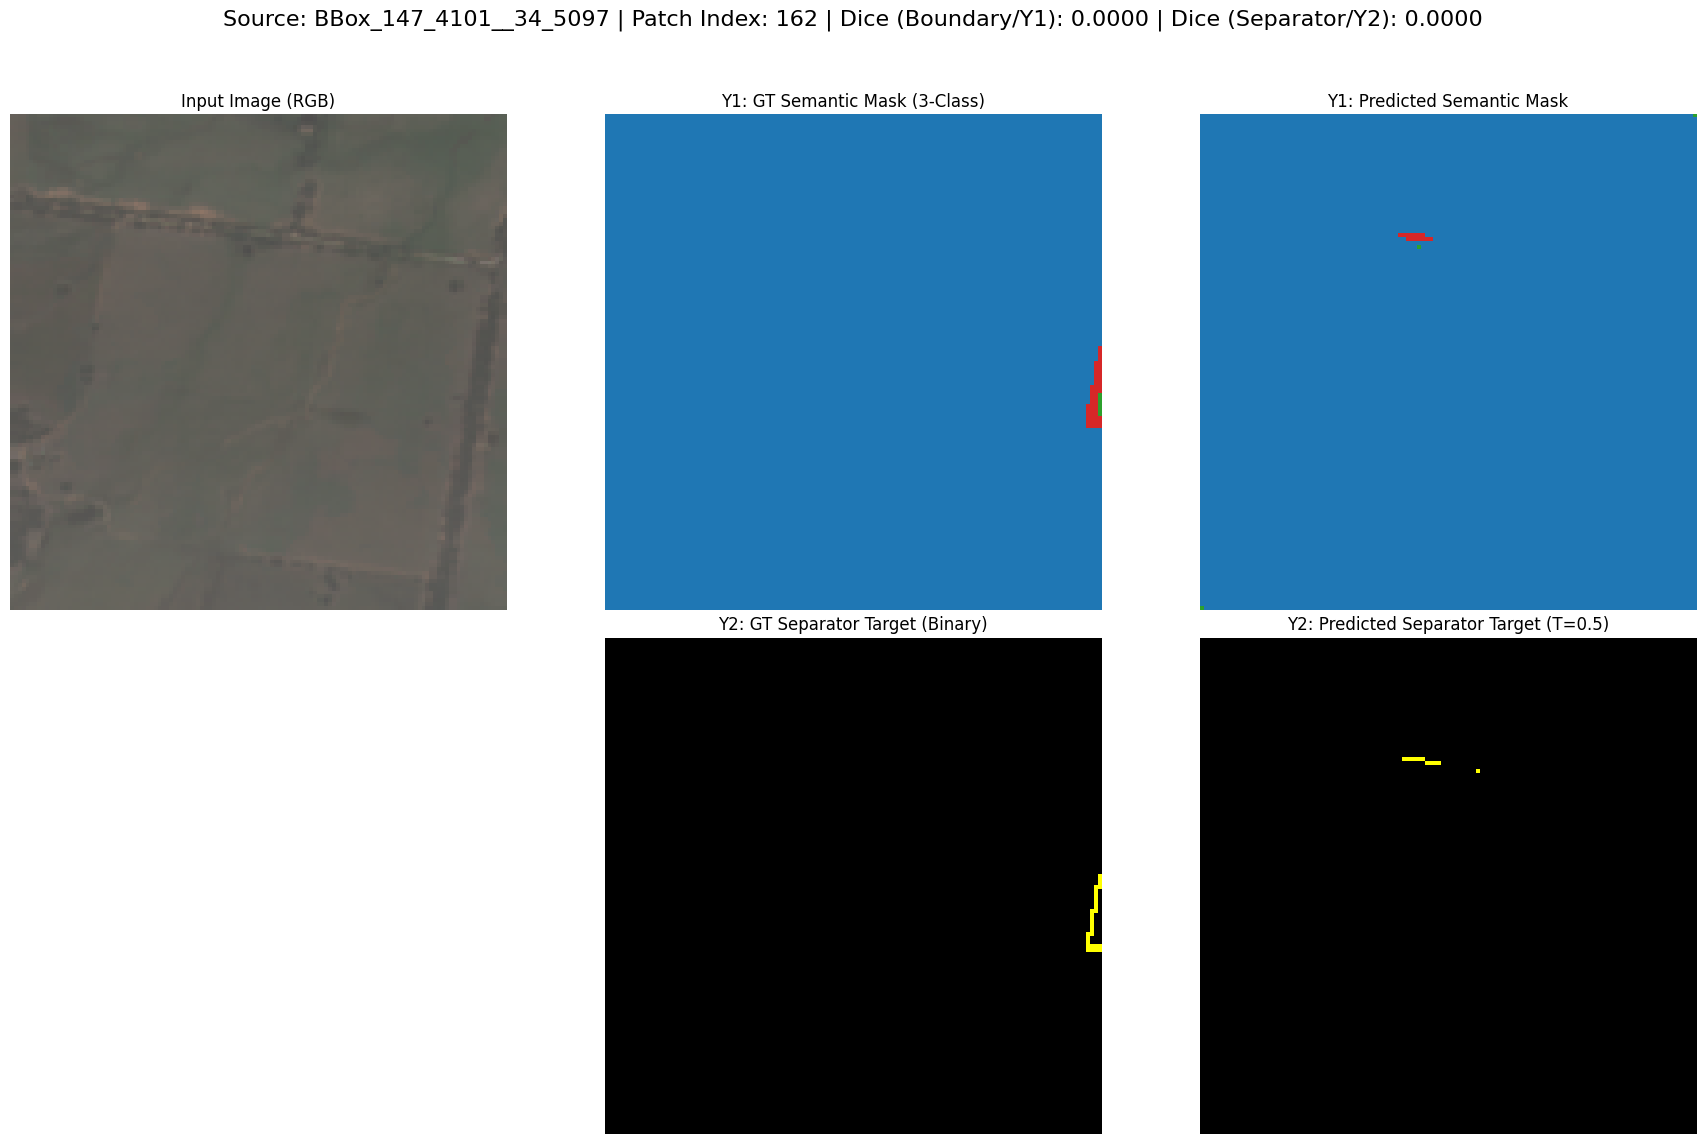

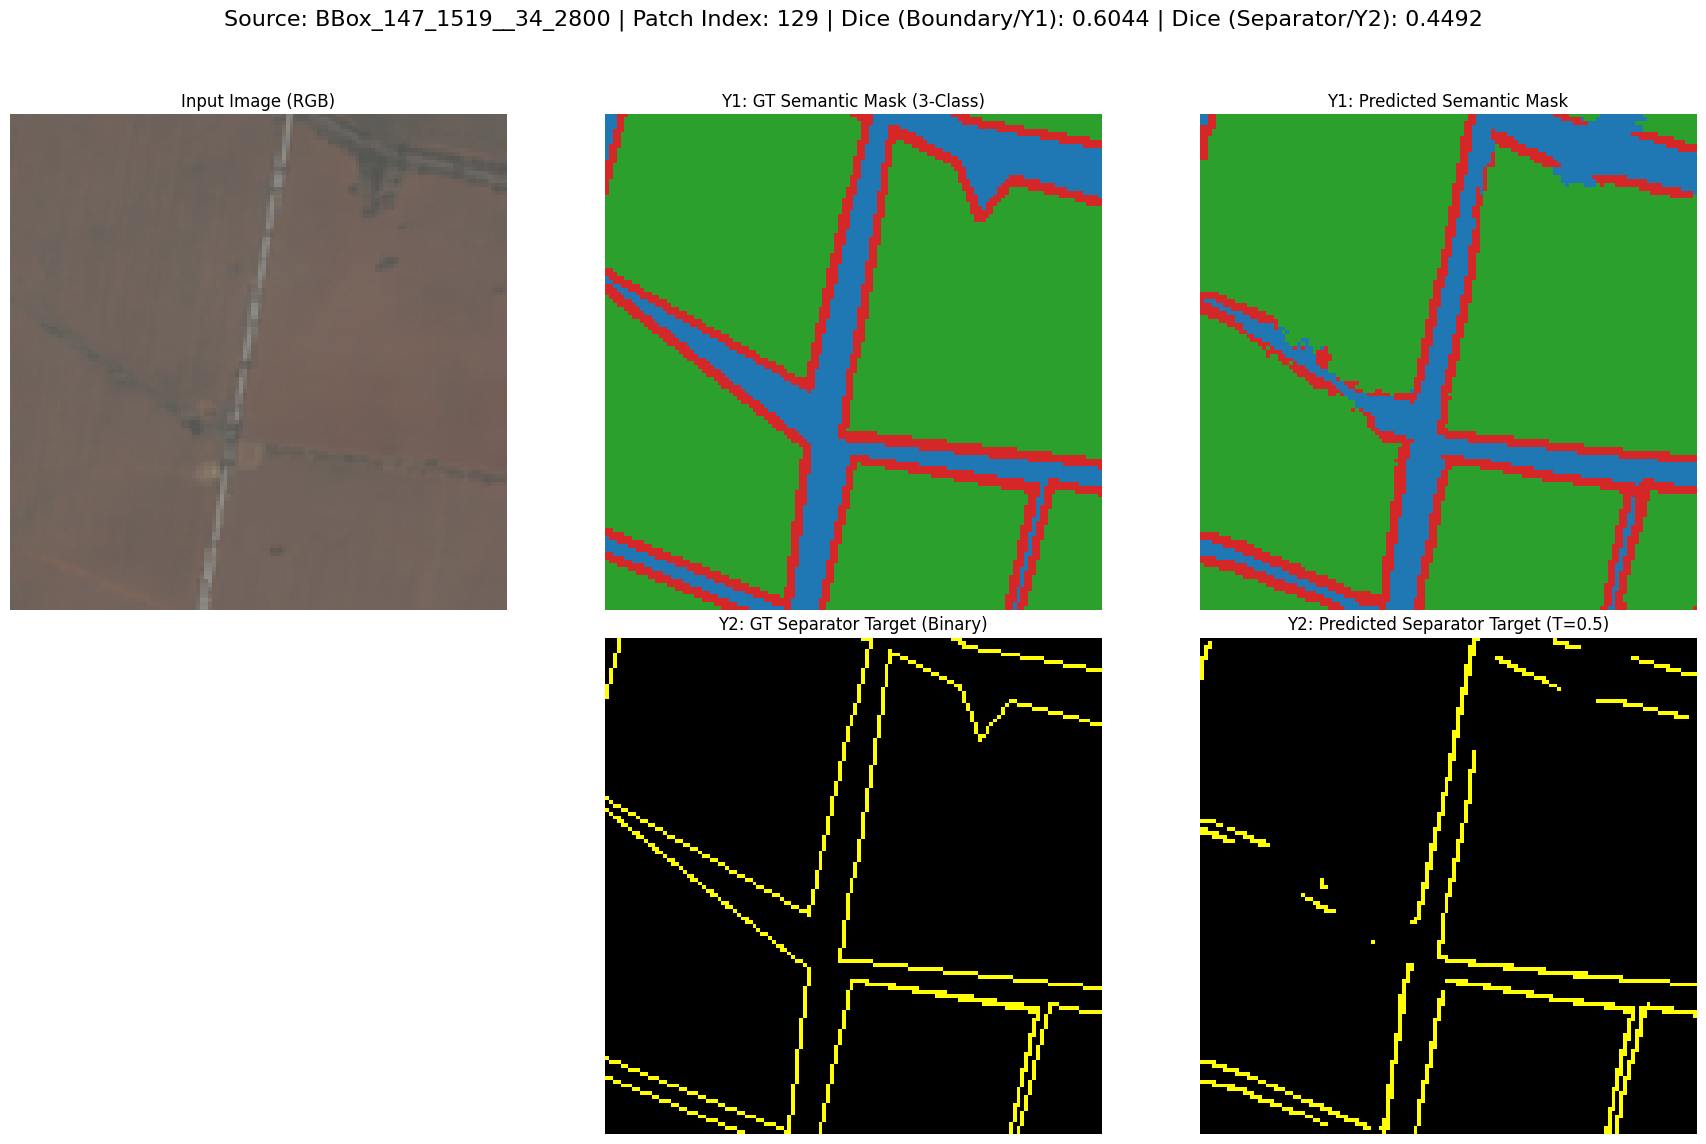

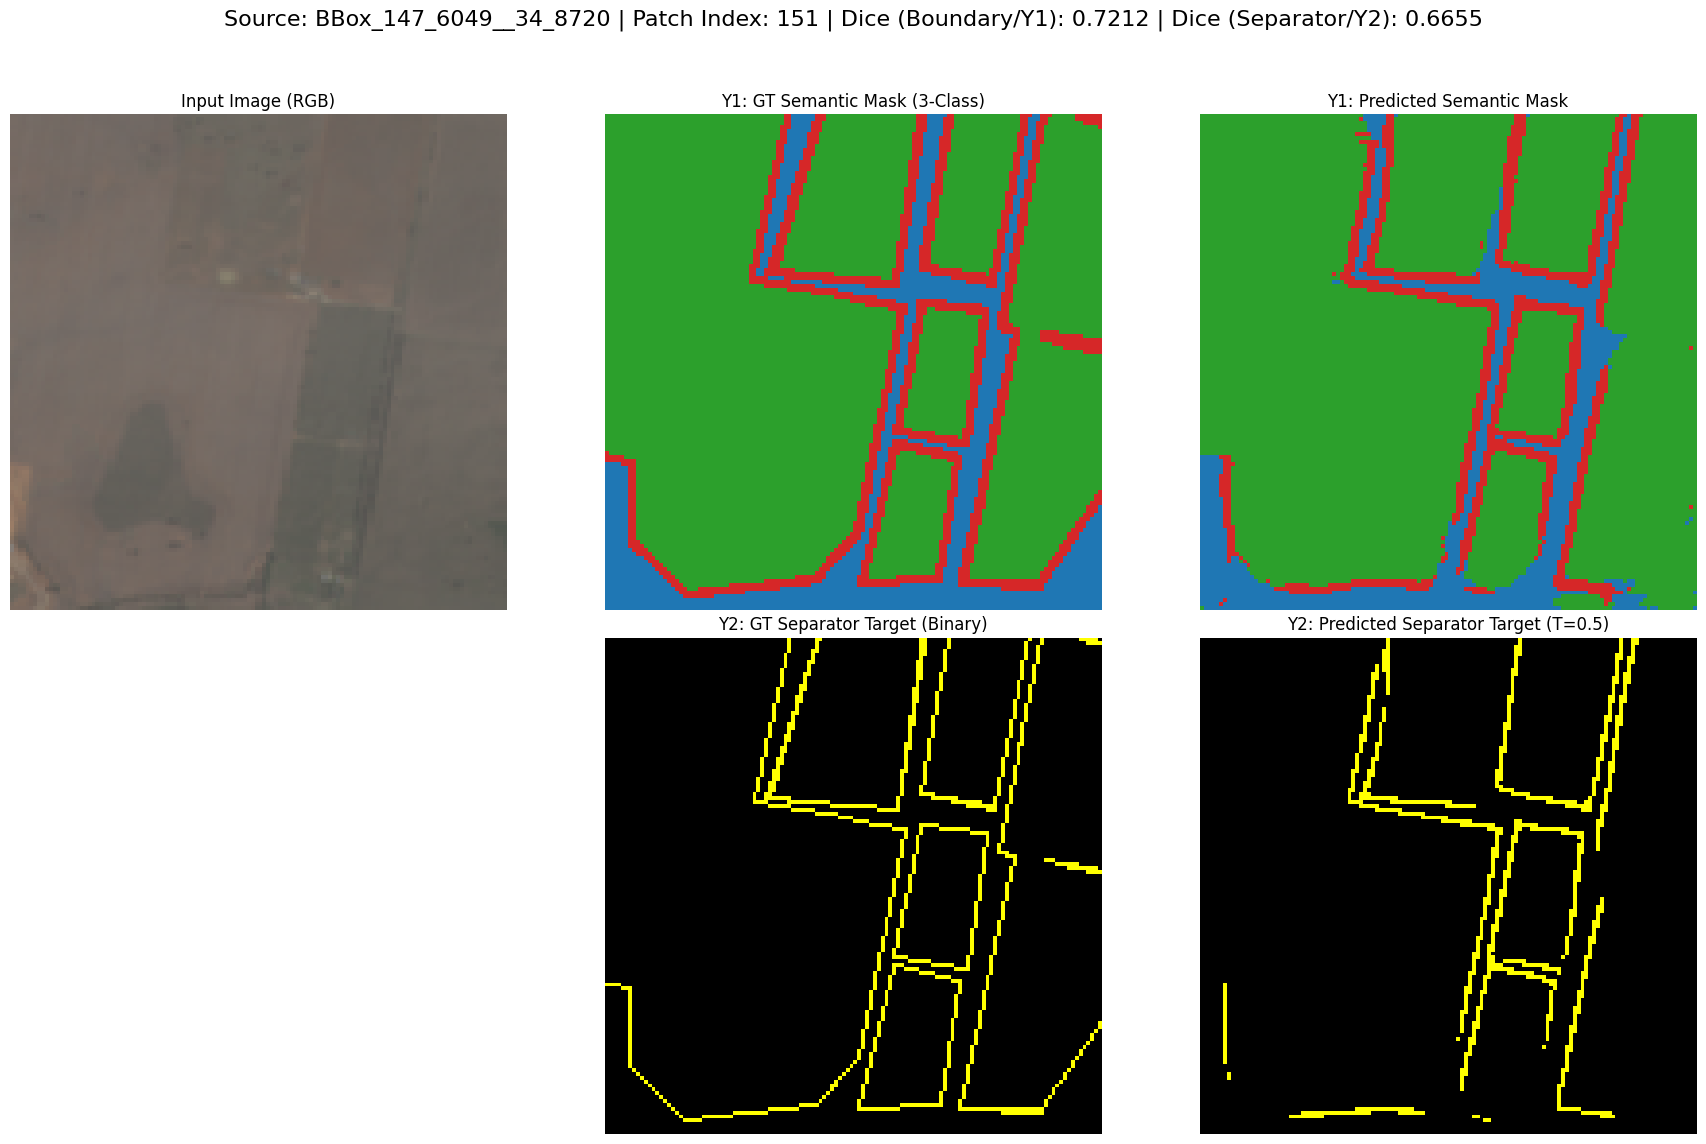

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors # Make sure you have this import!

# --- Visualization Function (Adapted for Dual Targets) ---

def z_score_denormalize(X_norm):
    """Placeholder function - Denormalization is handled by manual clipping/scaling below."""
    return X_norm

def visualize_dual_test_predictions(model, X_test, Y1_test, Y2_test, Source_test, num_samples=3):
    """
    Selects random patches from the test set, generates dual predictions (Y1 & Y2),
    and visualizes the Input Image, Ground Truth Masks, and Predicted Masks.
    """

    # Visualization Parameters for Sentinel-2 Z-scores
    R_BAND_IDX, G_BAND_IDX, B_BAND_IDX = 2, 1, 0
    Z_MIN = -3.0
    Z_MAX = 3.0

    # Custom Color Maps
    # Semantic Mask (Y1): 0-Non-Crop (Blue), 1-Interior (Green), 2-Boundary (Red)
    cmap_semantic = mcolors.ListedColormap(['#1f77b4', '#2ca02c', '#d62728'])
    # Separator Target (Y2): 0-Background (Black), 1-Separator (White/Yellow)
    cmap_separator = mcolors.ListedColormap(['black', 'yellow'])

    # 1. Select random indices from the test set
    num_test_patches = X_test.shape[0]
    num_samples = min(num_samples, num_test_patches)
    random_indices = np.random.choice(num_test_patches, size=num_samples, replace=False)

    print(f"--- Visualizing {num_samples} Random Dual-Target Test Samples ---")

    for i, idx in enumerate(random_indices):
        # 2. Extract single sample data
        X_sample = X_test[idx]
        Y1_true = Y1_test[idx]          # Semantic Mask (H, W, 1)
        Y2_true = Y2_test[idx]          # Separator Target (H, W, 1)
        source_name = Source_test[idx]

        # 3. Generate dual predictions
        X_batch = np.expand_dims(X_sample, axis=0)
        # Assuming your model returns two predictions: (Y1_pred_raw, Y2_pred_raw)
        Y1_pred_raw_batch, Y2_pred_raw_batch = model.predict(X_batch, verbose=0)

        # Squeeze batch dimension
        Y1_pred_raw = Y1_pred_raw_batch[0]
        Y2_pred_raw = Y2_pred_raw_batch[0]

        # 4. Process predictions for visualization & metrics

        # Y1 (Semantic Mask): Final output is class index (0, 1, 2)
        Y1_pred_class = np.argmax(Y1_pred_raw, axis=-1)

        # Y2 (Separator Target): Binary prediction (Threshold 0.5)
        Y2_pred_binary = (Y2_pred_raw > 0.5).astype(np.float32).squeeze()

        # --- Calculate Metrics (Dice Score) ---
        # For Y1, we can calculate Dice for the Boundary class (Class 2)
        Y1_true_binary = (Y1_true.squeeze() == 2).astype(np.float32)
        Y1_pred_binary = (Y1_pred_class == 2).astype(np.float32)

        dice_y1 = (2. * np.sum(Y1_true_binary * Y1_pred_binary)) / (np.sum(Y1_true_binary) + np.sum(Y1_pred_binary) + 1e-6)
        dice_y2 = (2. * np.sum(Y2_true.squeeze() * Y2_pred_binary)) / (np.sum(Y2_true.squeeze()) + np.sum(Y2_pred_binary) + 1e-6)


        # 5. Prepare Input Image for visualization (same as before)
        rgb_normalized = X_sample[:, :, [R_BAND_IDX, G_BAND_IDX, B_BAND_IDX]]
        rgb_image = np.clip((rgb_normalized - Z_MIN) / (Z_MAX - Z_MIN), 0, 1)

        # 6. Plot the results in a 2x3 grid
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        fig.suptitle(
            f"Source: {source_name} | Patch Index: {idx} | "
            f"Dice (Boundary/Y1): {dice_y1:.4f} | Dice (Separator/Y2): {dice_y2:.4f}",
            fontsize=16
        )

        # --- Row 1: Input & Semantic Mask (Y1) ---

        # (0, 0) Plot 1: Input Image (RGB Composite)
        axes[0, 0].imshow(rgb_image)
        axes[0, 0].set_title('Input Image (RGB)')
        axes[0, 0].axis('off')

        # (0, 1) Plot 2: Ground Truth Semantic Mask (Y1)
        axes[0, 1].imshow(Y1_true.squeeze(), cmap=cmap_semantic, vmin=0, vmax=2)
        axes[0, 1].set_title('Y1: GT Semantic Mask (3-Class)')
        axes[0, 1].axis('off')

        # (0, 2) Plot 3: Predicted Semantic Mask (Y1)
        axes[0, 2].imshow(Y1_pred_class, cmap=cmap_semantic, vmin=0, vmax=2)
        axes[0, 2].set_title('Y1: Predicted Semantic Mask')
        axes[0, 2].axis('off')

        # --- Row 2: Separator Target (Y2) ---

        # (1, 0) Plot 4: Input Image (Blanked out, or a copy of Input)
        axes[1, 0].remove() # Remove the extra subplot

        # (1, 1) Plot 5: Ground Truth Separator Target (Y2)
        axes[1, 1].imshow(Y2_true.squeeze(), cmap=cmap_separator, vmin=0, vmax=1)
        axes[1, 1].set_title('Y2: GT Separator Target (Binary)')
        axes[1, 1].axis('off')

        # (1, 2) Plot 6: Predicted Separator Target (Y2)
        axes[1, 2].imshow(Y2_pred_binary, cmap=cmap_separator, vmin=0, vmax=1)
        axes[1, 2].set_title('Y2: Predicted Separator Target (T=0.5)')
        axes[1, 2].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# --- Example Execution ---
# You need to call the new function with the new test arrays:
visualize_dual_test_predictions(model, X_test, Y1_test, Y2_test, Source_test, num_samples=3)

In [ ]:
Debugging

In [29]:
from collections import defaultdict
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# --- Configuration (Ensure these match your notebook config!) ---
R_BAND_IDX, G_BAND_IDX, B_BAND_IDX = 2, 1, 0
Z_MIN = -3.0
Z_MAX = 3.0
PATCH_SIZE = 128
STRIDE = 64
# ----------------------------------------------------------------

def reconstruct_and_visualize_bbox(model, X_test, Y1_test, Y2_test, Source_test, Index_test, bbox_name_to_reconstruct, bbox_dims):
    # ... rest of the function
    """
    Selects a specified BBox from the test set, reconstructs the full image
    and predictions, performs Watershed, and visualizes the result.
    """

    if bbox_name_to_reconstruct not in bbox_dims:
        print(f"ERROR: BBox name '{bbox_name_to_reconstruct}' not found in the dimensions map.")
        return

    # 1. Get the dimensions for this specific BBox
    H_ORIGINAL, W_ORIGINAL = bbox_dims[bbox_name_to_reconstruct]

    # 2. Filter patches for the target BBox
    source_to_indices = defaultdict(list)
    for i, source in enumerate(Source_test):
        source_to_indices[source].append(i)

    if bbox_name_to_reconstruct not in source_to_indices:
        print(f"ERROR: No patches from '{bbox_name_to_reconstruct}' found in the TEST set.")
        return

    test_indices = source_to_indices[bbox_name_to_reconstruct]

    # 1. Get the patches and their indices for this BBox
    X_bbox_patches_unsorted = X_test[test_indices]
    patch_indices = Index_test[test_indices] # <--- NEW: Get the (row, col) indices

    if patch_indices.ndim == 1:
        # The new shape is (number_of_patches, 2 coordinates)
        num_patches = len(X_bbox_patches_unsorted)
        # We use -1 to let NumPy calculate the first dimension size
        patch_indices = patch_indices.reshape(-1, 2)

    # 2. Find the sort order based on the patch indices
    # We sort by row (index 0) then by column (index 1)
    sort_order = np.lexsort((patch_indices[:, 1], patch_indices[:, 0]))

    # 3. Apply the sort order
    X_bbox_patches = X_bbox_patches_unsorted[sort_order] # <--- NEW: Sorted patches
    print(f"--- Reconstructing BBox: {bbox_name_to_reconstruct} (H={H_ORIGINAL}, W={W_ORIGINAL}) using {X_bbox_patches.shape[0]} patches ---")


    # 3. Generate Predictions and Reconstruction
    Y_pred_semantic_patches, Y_pred_separator_patches = model.predict(X_bbox_patches, verbose=0)

    reconstructed_semantic = reconstruct_image(Y_pred_semantic_patches, H_ORIGINAL, W_ORIGINAL, PATCH_SIZE, STRIDE)
    reconstructed_separator = reconstruct_image(Y_pred_separator_patches, H_ORIGINAL, W_ORIGINAL, PATCH_SIZE, STRIDE)
    reconstructed_X_rgb = reconstruct_image(X_bbox_patches[:, :, :, [R_BAND_IDX, G_BAND_IDX, B_BAND_IDX]],
                                            H_ORIGINAL, W_ORIGINAL, PATCH_SIZE, STRIDE)

    # 4. Post-Processing on Reconstructed Image
    # The reconstruction averages the softmax/sigmoid values across overlaps, resulting in smooth inputs for Watershed
    final_instance_mask = watershed_post_processing(reconstructed_semantic, reconstructed_separator)

    # --- VISUALIZATION ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot 1: Input Image
    rgb_image = np.clip((reconstructed_X_rgb - Z_MIN) / (Z_MAX - Z_MIN), 0, 1)
    axes[0].imshow(rgb_image)
    axes[0].set_title(f'BBox: {bbox_name_to_reconstruct} | Input Image (RGB)')
    axes[0].axis('off')

    # Plot 2: Semantic Prediction (3-Class)
    reco_semantic_class = np.argmax(reconstructed_semantic, axis=-1)
    cmap_semantic = mcolors.ListedColormap(['#1f77b4', '#2ca02c', '#d62728']) # Blue, Green, Red for (0, 1, 2)
    axes[1].imshow(reco_semantic_class, cmap=cmap_semantic, vmin=0, vmax=2)
    axes[1].set_title('Semantic Prediction (0:Non-Crop, 1:Interior, 2:Boundary)')
    axes[1].axis('off')

    # Plot 3: Final Instance Prediction (Watershed Result)
    # Use a random color map for the individual instance IDs
    # Note: Instance 0 is typically background/unlabeled
    num_instances = np.max(final_instance_mask)

    axes[2].imshow(final_instance_mask.squeeze(), cmap='nipy_spectral', vmin=0, vmax=num_instances)
    axes[2].set_title(f'FINAL Instance Prediction (Found: {num_instances} Fields)')
    axes[2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- Example Execution (After training) ---
BBOX_NAME_TO_VIEW = 'BBox_147_4101__34_5097'
# 🛑 NEW ARGUMENT: Index_test is added here
reconstruct_and_visualize_bbox(model, X_test, Y1_test, Y2_test, Source_test, Index_test, BBOX_NAME_TO_VIEW, bbox_dims)

ValueError: cannot reshape array of size 43 into shape (2)